In [1]:
!pwd

/Users/ashish1610dhiman/data_projects/bestbuy/notebooks/ashish_validation_train


In [2]:
import sys
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

sys.version

sys.path.append("../../")

# from src.ad_hmm import sku_predict
# from src.ad_stl_model import stl_model
from src.utils import *

In [3]:
%load_ext autoreload 
%autoreload 2

### y-actual

In [4]:
original_validation = pd.read_excel("../../data/Validation_Data.xlsx").drop_duplicates()
y_act = original_validation[["Encoded_SKU_ID","SALES_DATE","DAILY_UNITS"]].rename(columns = {"DAILY_UNITS":"actual"})
y_act.head()

,Encoded_SKU_ID,SALES_DATE,actual
0,23,2022-08-06,3
1,100,2022-08-02,2
2,121,2022-08-06,6
3,207,2022-08-03,0
4,416,2022-08-05,9


###  Read all predictions

In [5]:
#y_null
y_pred_null = pd.read_csv("../../results/null_model_results_final.csv",index_col=0)
y_pred_null["SALES_DATE"] = pd.to_datetime(y_pred_null["SALES_DATE"])
y_pred_null.Encoded_SKU_ID.nunique()

539

In [6]:
y_pred_null.count(),y_pred_null.drop_duplicates().count()

(Encoded_SKU_ID    3773
 SALES_DATE        3773
 predicted         3773
 dtype: int64,
 Encoded_SKU_ID    3773
 SALES_DATE        3773
 predicted         3773
 dtype: int64)

In [7]:
#y_holt
y_pred_holt = pd.read_csv("../../results/holt_rst_final_02.csv",index_col=0)
y_pred_holt["SALES_DATE"] = pd.to_datetime(y_pred_holt["SALES_DATE"])
y_pred_holt.Encoded_SKU_ID.nunique()

41

In [8]:
y_pred_holt.count(),y_pred_holt.drop_duplicates().count()

(SALES_DATE        287
 predicted         287
 Encoded_SKU_ID    287
 dtype: int64,
 SALES_DATE        287
 predicted         287
 Encoded_SKU_ID    287
 dtype: int64)

In [10]:
#y_hmm
y_pred_hmm = pd.read_csv("../../results/hmm_result_final_all2.csv").drop(columns=["Unnamed: 0"])
y_pred_hmm["SALES_DATE"] = pd.to_datetime(y_pred_hmm["SALES_DATE"])
y_pred_hmm.Encoded_SKU_ID.nunique()

300

In [11]:
y_pred_hmm.count(),y_pred_hmm.drop_duplicates().count()

(SALES_DATE        2340
 predicted         1906
 predicted_30      1976
 predicted_45      1969
 predicted_60      1962
 predicted_90      1962
 predicted_max     1955
 Encoded_SKU_ID    2340
 dtype: int64,
 SALES_DATE        2340
 predicted         1906
 predicted_30      1976
 predicted_45      1969
 predicted_60      1962
 predicted_90      1962
 predicted_max     1955
 Encoded_SKU_ID    2340
 dtype: int64)

In [12]:
#y_prophet_stl
import pickle
with open('../../data/stl_prophet_final_results_127sku2.pkl', 'rb') as f:
    all_preds = pickle.load(f)
    
y_pred_prophet_stl_mstl = pd.DataFrame()
for i in range(len(all_preds)):
    if all_preds[i]!= None:
        y_pred_prophet_stl_mstl = pd.concat([y_pred_prophet_stl_mstl,all_preds[i][1]])
y_pred_prophet_stl_mstl = y_pred_prophet_stl_mstl.reset_index().drop(columns=["actual"])
y_pred_prophet_stl_mstl["SALES_DATE"] = pd.to_datetime(y_pred_prophet_stl_mstl["SALES_DATE"])
y_pred_prophet_stl_mstl.Encoded_SKU_ID.nunique()

Importing plotly failed. Interactive plots will not work.


219

In [13]:
y_pred_prophet_stl_mstl.count(),y_pred_prophet_stl_mstl.drop_duplicates().count()

(SALES_DATE            1533
 STL_prediction        1530
 MSTL_prediction       1531
 prophet_prediction    1533
 Encoded_SKU_ID        1533
 dtype: int64,
 SALES_DATE            1533
 STL_prediction        1530
 MSTL_prediction       1531
 prophet_prediction    1533
 Encoded_SKU_ID        1533
 dtype: int64)

In [14]:
y_pred_stl = y_pred_prophet_stl_mstl[["SALES_DATE","STL_prediction","Encoded_SKU_ID"\
                        ]].rename(columns={"STL_prediction":"predicted"})

y_pred_mstl = y_pred_prophet_stl_mstl[["SALES_DATE","MSTL_prediction","Encoded_SKU_ID"\
                        ]].rename(columns={"MSTL_prediction":"predicted"})

y_pred_prophet = y_pred_prophet_stl_mstl[["SALES_DATE","prophet_prediction","Encoded_SKU_ID"\
                        ]].rename(columns={"prophet_prediction":"predicted"})

### Merge all predictions

In [15]:
print("null",y_pred_null["Encoded_SKU_ID"].nunique())
print("stl",y_pred_stl["Encoded_SKU_ID"].nunique())
print("mstl",y_pred_mstl["Encoded_SKU_ID"].nunique())
print("holt",y_pred_holt["Encoded_SKU_ID"].nunique())
print("hmm",y_pred_hmm["Encoded_SKU_ID"].nunique())
print("prophet",y_pred_prophet["Encoded_SKU_ID"].nunique())

null 539
stl 219
mstl 219
holt 41
hmm 300
prophet 219


In [16]:
y_pred_holt1 = y_pred_holt.rename(columns={"predicted":"predicted_holt"})

In [17]:
all_predictions = y_pred_hmm.merge(y_pred_prophet_stl_mstl,on=["Encoded_SKU_ID","SALES_DATE"],how="outer"\
                                            ).merge(y_pred_null,on=["Encoded_SKU_ID","SALES_DATE"],how="outer",\
                                                   suffixes = ("_15","_null"),\
                                                   ).merge(y_pred_holt1,on=["Encoded_SKU_ID","SALES_DATE"],how="outer"\
                                                          ,suffixes=("","_holt")).drop_duplicates()
all_predictions.head()

,SALES_DATE,predicted_15,predicted_30,predicted_45,predicted_60,predicted_90,predicted_max,Encoded_SKU_ID,STL_prediction,MSTL_prediction,prophet_prediction,predicted_null,predicted_holt
0,2022-08-01,3.00,3.00,3.00,3.00,2.00,3.00,1,NaN,NaN,NaN,1,NaN
1,2022-08-01,1.55,0.45,0.45,0.45,2.00,1.00,1,NaN,NaN,NaN,1,NaN
2,2022-08-01,1.55,1.55,1.00,2.00,2.00,2.00,1,NaN,NaN,NaN,1,NaN
3,2022-08-01,3.00,3.00,2.00,3.00,1.45,0.45,1,NaN,NaN,NaN,1,NaN
4,2022-08-01,1.00,0.00,0.00,2.00,2.00,2.00,1,NaN,NaN,NaN,1,NaN


In [18]:
all_predictions = all_predictions.rename(columns={
    "STL_prediction":"predicted_STL",\
    "MSTL_prediction":"predicted_MSTL",\
    "prophet_prediction":"predicted_prophet"
})

### Create Aggregare prediction

In [19]:
rmse_all_preds = pd.DataFrame()
first_flag = True
for col in all_predictions.columns:
    if "pred" in col:
        y_pred_i = all_predictions[["Encoded_SKU_ID","SALES_DATE",col\
                                   ]].rename(columns={col:"predicted"})
        y_pred_i["SALES_DATE"] = pd.to_datetime(y_pred_i["SALES_DATE"])
        rmse_pred_i = rmse_sku(y_act,y_pred_i)
        rmse_pred_i.columns = [f"{col_rmse}_{col.split('_')[-1]}" for col_rmse in rmse_pred_i.columns]
        if first_flag:
            rmse_all_preds = rmse_pred_i
            print (col,rmse_all_preds.shape)
            first_flag = False
        else:
            rmse_all_preds = rmse_all_preds.merge(rmse_pred_i, left_index = True, right_index = True,\
                                suffixes = ("",f"_{col.split('_')[-1]}"))
            print (col,rmse_all_preds.shape)

predicted_15 (539, 3)
predicted_30 (539, 6)
predicted_45 (539, 9)
predicted_60 (539, 12)
predicted_90 (539, 15)
predicted_max (539, 18)
predicted_STL (539, 21)
predicted_MSTL (539, 24)
predicted_prophet (539, 27)
predicted_null (539, 30)
predicted_holt (539, 33)


In [20]:
rmse_cols = [col for col in rmse_all_preds.columns if "rmse_du" in col]
rmse_cols

['rmse_du_15',
 'rmse_du_30',
 'rmse_du_45',
 'rmse_du_60',
 'rmse_du_90',
 'rmse_du_max',
 'rmse_du_STL',
 'rmse_du_MSTL',
 'rmse_du_prophet',
 'rmse_du_null',
 'rmse_du_holt']

In [21]:
rmse_all_preds["min_rmse"] = rmse_all_preds[rmse_cols].min(axis=1,skipna=True)

rmse_all_preds["argmin_period"] = np.nanargmin(rmse_all_preds[rmse_cols].values,axis=1)

rmse_all_preds["min_period"] = rmse_all_preds["argmin_period"].apply(lambda x: rmse_cols[x])

In [22]:
rmse_all_preds["min_period"].value_counts()

rmse_du_null       205
rmse_du_prophet     68
rmse_du_STL         65
rmse_du_15          39
rmse_du_60          30
rmse_du_90          29
rmse_du_max         29
rmse_du_30          27
rmse_du_45          23
rmse_du_MSTL        15
rmse_du_holt         9
Name: min_period, dtype: int64

In [23]:
period_col_map= {
    "rmse_du_15":"predicted_15", "rmse_du_30":"predicted_30", "rmse_du_45":"predicted_45",\
    "rmse_du_60":"predicted_60", "rmse_du_90":"predicted_90", "rmse_du_max":"predicted_max",\
    "rmse_du_STL":"predicted_STL","rmse_du_MSTL":"predicted_MSTL","rmse_du_null":"predicted_null",\
    "rmse_du_holt":"predicted_holt","rmse_du_prophet":"predicted_prophet"
}

In [24]:
y_pred_best = pd.DataFrame()
cnt = 0
for sku_id,best_period in zip(rmse_all_preds.index,rmse_all_preds["min_period"]):
    best_col = period_col_map[best_period]
    mask_sku = all_predictions.Encoded_SKU_ID==sku_id
    y_pred_best_sku = all_predictions.loc[mask_sku][["Encoded_SKU_ID","SALES_DATE",best_col\
                                                                  ]].rename(columns={best_col:"predicted"})
    y_pred_best = pd.concat([y_pred_best,y_pred_best_sku])

In [25]:
#QC
y_act.Encoded_SKU_ID.nunique(),y_pred_null.Encoded_SKU_ID.nunique(),y_pred_best.Encoded_SKU_ID.nunique()

(539, 539, 539)

In [26]:
y_pred_best.count(),y_pred_best.drop_duplicates().count()

(Encoded_SKU_ID    4013
 SALES_DATE        4013
 predicted         3992
 dtype: int64,
 Encoded_SKU_ID    3872
 SALES_DATE        3872
 predicted         3851
 dtype: int64)

In [27]:
rmse_val_null,rmse_null_best = rmse(y_act,y_pred_null),rmse(y_act,y_pred_best)
rmse_val_null,rmse_null_best

(5.290976671399268, 3.1536214276397208)

In [57]:
y_pred_best1 = y_pred_best.drop_duplicates(subset=["Encoded_SKU_ID","SALES_DATE"])

In [60]:
y_pred_best1.to_csv("../../results/final_predictions_ensemble_models.csv")

In [151]:
y_pred_best2 = pd.read_csv("../../results/final_predictions_ensemble_models.csv",index_col=0)
y_pred_best2["SALES_DATE"] = pd.to_datetime(y_pred_best2["SALES_DATE"], format ="%d/%m/%y")
y_pred_best2.head()

,Encoded_SKU_ID,SALES_DATE,predicted
511,482,2022-08-01,5.267713
512,482,2022-08-02,4.981521
513,482,2022-08-03,4.476764
514,482,2022-08-04,4.905987
515,482,2022-08-05,5.636263


In [152]:
y_act["SALES_DATE"]

0      2022-08-06
1      2022-08-02
2      2022-08-06
3      2022-08-03
4      2022-08-05
          ...    
3768   2022-08-06
3769   2022-08-02
3770   2022-08-01
3771   2022-08-01
3772   2022-08-04
Name: SALES_DATE, Length: 3773, dtype: datetime64[ns]

In [154]:
rmse_val_null,rmse_null_best = rmse(y_act,y_pred_null),rmse(y_act,y_pred_best2)
rmse_val_null,rmse_null_best

(5.290976671399268, 2.2094858172197425)

In [155]:
y_pred_best2.to_csv("../../results/final_predictions_ensemble_models.csv")

In [124]:
df_join = y_act.merge(y_pred_best2,on=["Encoded_SKU_ID","SALES_DATE"])
df_join

,Encoded_SKU_ID,SALES_DATE,actual,predicted


In [156]:
rmse_best_sku = rmse_sku(y_act,y_pred_best2)

In [157]:
rmse_best_sku["rmse_du"].quantile([0.9,0.95,0.99])

0.90    2.943019
0.95    4.361333
0.99    7.253910
Name: rmse_du, dtype: float64

<AxesSubplot: >

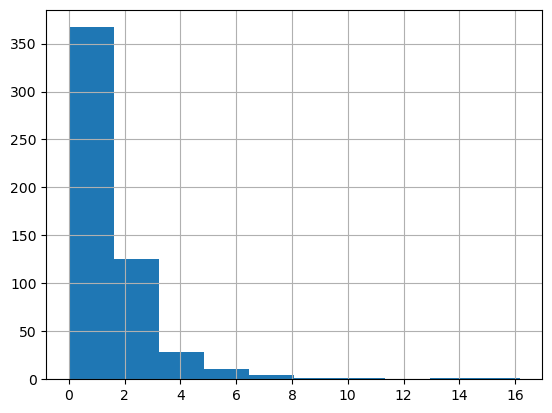

In [158]:
rmse_best_sku["rmse_du"].hist()

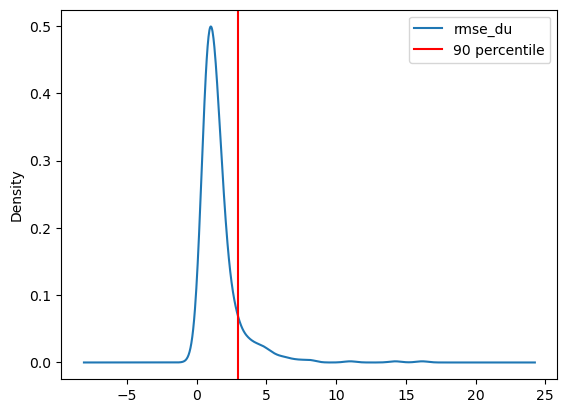

In [159]:
# rmse_best_sku["rmse_du"].hist()
rmse_best_sku["rmse_du"].plot(kind="kde")
plt.axvline(2.94, color="red", label = "90 percentile")
plt.legend()

In [61]:
rmse_best_sku.head(10)

,rmse_du,mean_du,pct_rmse
Encoded_SKU_ID,,,
430,40.362642,94.714286,0.426152
469,33.161158,396.000000,0.083740
557,22.696759,33.285714,0.681877
271,16.694738,28.428571,0.587252
50,11.004702,73.857143,0.149000
74,8.246211,41.142857,0.200429
350,7.991066,13.428571,0.595079
381,7.386123,6.714286,1.100061
99,7.038193,10.857143,0.648255


In [67]:
y_act[y_act.Encoded_SKU_ID==271].sort_values(by=["SALES_DATE"])

,Encoded_SKU_ID,SALES_DATE,actual
366,271,2022-08-01,25
2193,271,2022-08-02,24
688,271,2022-08-03,27
2944,271,2022-08-04,30
1290,271,2022-08-05,38
3403,271,2022-08-06,41
1823,271,2022-08-07,14


In [ ]:
rmse_best_sku.tail()

### RMSE

In [ ]:
rmse_all_preds = pd.DataFrame()
first_flag = True
for col in all_predictions.columns:
    if "pred" in col:
        y_pred_i = all_predictions[["Encoded_SKU_ID","SALES_DATE",col\
                                   ]].rename(columns={col:"predicted"})
        y_pred_i["SALES_DATE"] = pd.to_datetime(y_pred_i["SALES_DATE"])
        rmse_pred_i = rmse_sku(y_act,y_pred_i)
        rmse_pred_i.columns = [f"{col_rmse}_{col.split('_')[-1]}" for col_rmse in rmse_pred_i.columns]
        if first_flag:
            rmse_all_preds = rmse_pred_i
            print (col,rmse_all_preds.shape)
            first_flag = False
        else:
            rmse_all_preds = rmse_all_preds.merge(rmse_pred_i, left_index = True, right_index = True,\
                                suffixes = ("",f"_{col.split('_')[-1]}"))
            print (col,rmse_all_preds.shape)

In [ ]:
rmse_all_preds

In [ ]:
rmse_cols = [col for col in rmse_all_preds.columns if "rmse_du" in col]
rmse_cols

In [ ]:
# #mute rmse null wherever other model is available to prevent data leak
# rmse_cols_wo_null = [x for x in rmse_cols if "null" not in x]
# atleast_one_model_not_nan = (~rmse_all_preds[rmse_cols_wo_null].isna()).sum(axis=1)>0
# atleast_one_model_not_nan.sum(),(~atleast_one_model_not_nan).sum()

In [ ]:
# rmse_all_preds.loc[atleast_one_model_not_nan,"rmse_null"]=np.nan

### Create y_best cumulatively | Ensemble

In [32]:
def create_y_best(rmse_all_preds,step_cols,period_col_map,step=""):
    rmse_all_preds[f"min_rmse_{step}"] = rmse_all_preds[step_cols].min(axis=1,skipna=True)
    rmse_all_preds[f"argmin_period_{step}"] = np.nanargmin(rmse_all_preds[step_cols].values,axis=1)
    rmse_all_preds[f"min_period_{step}"] = rmse_all_preds[f"argmin_period_{step}"].apply(lambda x: step_cols[x])
    y_pred_best = pd.DataFrame()
    cnt = 0
    for sku_id,best_period in zip(rmse_all_preds.index,rmse_all_preds[f"min_period_{step}"]):
        best_col = period_col_map[best_period]
        mask_sku = all_predictions.Encoded_SKU_ID==sku_id
        y_pred_best_sku = all_predictions.loc[mask_sku][["Encoded_SKU_ID","SALES_DATE",best_col\
                                                                  ]].rename(columns={best_col:"predicted"})
        y_pred_best = pd.concat([y_pred_best,y_pred_best_sku])
    return (y_pred_best)

In [ ]:
period_col_map= {
    "rmse_du_15":"predicted_15", "rmse_du_30":"predicted_30", "rmse_du_45":"predicted_45",\
    "rmse_du_60":"predicted_60", "rmse_du_90":"predicted_90", "rmse_du_max":"predicted_max",\
    "rmse_du_STL":"predicted_STL","rmse_du_MSTL":"predicted_MSTL","rmse_du_null":"predicted_null",\
    "rmse_du_holt":"predicted_holt","rmse_du_prophet":"predicted_prophet"
}

In [ ]:
rmse_cols

### Step 1: Null + Holt + Prophet

In [ ]:
step = "1"
step_cols = ['rmse_du_prophet',
 'rmse_du_null',
 'rmse_du_holt']

y_best1 = create_y_best(rmse_all_preds,step_cols,period_col_map,step)
assert y_best1.Encoded_SKU_ID.nunique()==539, "y_best does not have all SKUs"
rmse_val_null,rmse_null_best = rmse(y_act,y_pred_null),rmse(y_act,y_best1)
rmse_val_null,rmse_null_best,((rmse_val_null-rmse_null_best)*100)/rmse_null_best

In [ ]:
rmse_all_preds[f"min_period_{step}"].value_counts()

In [33]:
step = "2"
step_cols = ['rmse_du_STL',
 'rmse_du_MSTL',
 'rmse_du_prophet',
 'rmse_du_null',
 'rmse_du_holt']

y_best1 = create_y_best(rmse_all_preds,step_cols,period_col_map,step)
assert y_best1.Encoded_SKU_ID.nunique()==539, "y_best does not have all SKUs"
rmse_val_null,rmse_null_best = rmse(y_act,y_pred_null),rmse(y_act,y_best1)
rmse_val_null,rmse_null_best,((rmse_val_null-rmse_null_best)*100)/rmse_null_best

(5.290976671399268, 3.2293577822497923, 63.83990341612786)

In [ ]:
rmse_all_preds[f"min_period_{step}"].value_counts()

In [ ]:
### Step 1: Null + Holt + Prophet

step = "3"
step_cols = rmse_cols

y_best1 = create_y_best(rmse_all_preds,step_cols,period_col_map,step)
assert y_best1.Encoded_SKU_ID.nunique()==539, "y_best does not have all SKUs"
rmse_val_null,rmse_null_best = rmse(y_act,y_pred_null),rmse(y_act,y_best1)
rmse_val_null,rmse_null_best,((rmse_val_null-rmse_null_best)*100)/rmse_null_best

In [ ]:
rmse_all_preds[f"min_period_{step}"].value_counts()

In [ ]:
y_best1.Encoded_SKU_ID.value_counts()==7

In [ ]:
y_best1.count()

In [ ]:
y_best1.drop_duplicates().count()